In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
train_data = datasets.MNIST(
    root='data', 
    train= True,
    transform = ToTensor(),
    download = True
)
test_data = datasets.MNIST(
    root='data', 
    train= False,
    transform = ToTensor(),
    download = True
)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [6]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [7]:
train_data.data.size()

torch.Size([60000, 28, 28])

In [8]:
train_data.targets.size()

torch.Size([60000])

In [9]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [10]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
    'test': DataLoader(test_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1)    
}

In [11]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x12f795510>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x12f4b5f90>}

In [28]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # Call the dropout layer on the second convolutional layer
        x = x.view(-1, 320) # 20 channels for 4 * 4 through the convolutions
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return F.softmax(x)

In [31]:
import torch

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001) ## lr is learning rate and tutorial says this value is not that high

##Define a loss functionabs
loss_fn = nn.CrossEntropyLoss()

def train(epoch): # epich passed for loggingabs
    model.train() # needed for things like fropout to know the mode
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:            
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%\n)')

In [32]:
for epoch in range(1, 11):
    train(epoch)
    test()

/var/folders/gc/5ms21tc173j_j3xnz7sss5xnxhpl48/T/ipykernel_51274/651318756.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	2.303979
Train Epoch: 1 [2000/60000 (3%)]	2.284230
Train Epoch: 1 [4000/60000 (7%)]	2.140950
Train Epoch: 1 [6000/60000 (10%)]	2.099784
Train Epoch: 1 [8000/60000 (13%)]	1.914353
Train Epoch: 1 [10000/60000 (17%)]	1.900943
Train Epoch: 1 [12000/60000 (20%)]	1.844054
Train Epoch: 1 [14000/60000 (23%)]	1.835277
Train Epoch: 1 [16000/60000 (27%)]	1.848164
Train Epoch: 1 [18000/60000 (30%)]	1.807567
Train Epoch: 1 [20000/60000 (33%)]	1.770641
Train Epoch: 1 [22000/60000 (37%)]	1.748756
Train Epoch: 1 [24000/60000 (40%)]	1.667798
Train Epoch: 1 [26000/60000 (43%)]	1.669375
Train Epoch: 1 [28000/60000 (47%)]	1.665317
Train Epoch: 1 [30000/60000 (50%)]	1.689993
Train Epoch: 1 [32000/60000 (53%)]	1.640042
Train Epoch: 1 [34000/60000 (57%)]	1.672418
Train Epoch: 1 [36000/60000 (60%)]	1.664459
Train Epoch: 1 [38000/60000 (63%)]	1.693795
Train Epoch: 1 [40000/60000 (67%)]	1.668735
Train Epoch: 1 [42000/60000 (70%)]	1.602043
Train Epoch: 1 [44000/60000 (73%)]	1.641680

In [33]:
device

device(type='mps')

Prediction: 7


/var/folders/gc/5ms21tc173j_j3xnz7sss5xnxhpl48/T/ipykernel_51274/651318756.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


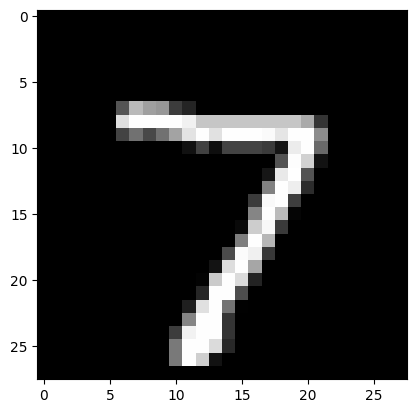

In [37]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[0]
data = data.unsqueeze(0).to(device)
output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap='gray')
plt.show()
plt.imsave('plot.png', image, cmap='gray')